In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from beta_irt.visualization.plots import newline
from beta_irt.visualization.plots import plot_parameters
from irt import beta_irt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import glob

In [3]:
name = 'polynomial'

In [4]:
names = []
path = './Results_IRT/'+name+'/'
foldernames = glob.glob(path+'*/')
keys = list(map(lambda x: int(x[:-1].split('_')[-1]), foldernames))
keys = sorted(range(len(keys)), key=lambda k: keys[k])
foldernames = list(map(lambda k: foldernames[k], keys))
names = list(map(lambda x: x.split('/')[-2], foldernames))
max_std = int(names[-1].split('_')[-1])

In [5]:
foldernames

['./Results_IRT/polynomial/noise_0/',
 './Results_IRT/polynomial/noise_7/',
 './Results_IRT/polynomial/noise_14/']

In [6]:
all_files = []
for i, df in enumerate(foldernames):
    path = df
    filenames = glob.glob(path + "/*.csv")
    filenames.sort()

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename))
    all_files.append(dfs)

# Histograms Responses

In [7]:
plts = ['Original', 'Noise 1', 'Noise 2']

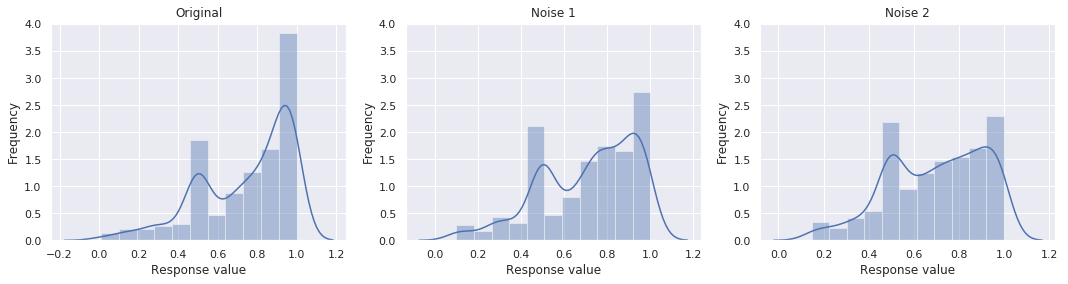

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))
scale = 0
for i, data in enumerate(all_files):
    values = data[1].values.reshape(-1,1)
    sns.distplot(values, ax= axes[i])
    current_scale = axes[i].get_ylim()[1] - axes[i].get_ylim()[0]
    if current_scale > scale:
        scale = current_scale
        y_lim = axes[i].get_ylim()
    axes[i].set_title(plts[i])
    axes[i].set_xlabel('Response value')
    axes[i].set_ylabel('Frequency')
for ax in axes:
    ax.set_ylim(y_lim)
fig.savefig('./Results_IRT/'+name+'/hists.png')

# Difficulty/ Discrimination

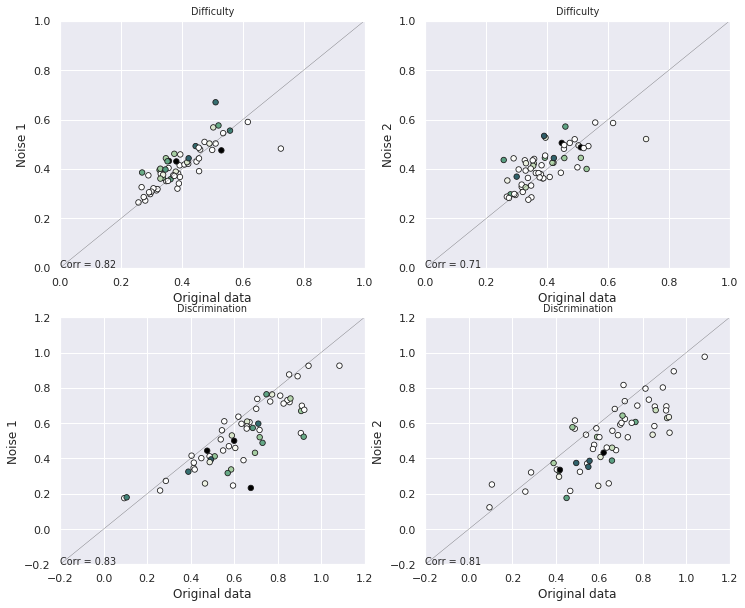

In [9]:
plot = ["Difficulty", "Discrimination"]
#Lower noise
scale = 0
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for i, title in enumerate(plot):
    for j in range(1,3):
        if i == 0:
            lim = np.array([0,1])
        else:
            lim = np.array([-0.2, 1.2])
        
        axes[i,j-1].set_xlim(lim)
        axes[i,j-1].set_ylim(lim)
        axes[i,j-1].plot([lim[0],lim[1]], [lim[0], lim[1]], linewidth=0.2, c='black')        
        
        sns.set_context('paper')
        cmap1 = sns.cubehelix_palette(rot=-.5,light=1.5,dark=-.5,as_cmap=True)

        axes[i,j-1].text(x = lim[0], y = lim[0], s='Corr = %.2f' %(all_files[0][2].iloc[:,i].corr(other = all_files[j][2].iloc[:,i])))
        axes[i, j-1].scatter(all_files[0][2].iloc[:,i], all_files[j][2].iloc[:,i], c = np.absolute(all_files[j][3].iloc[:,-1]), cmap = cmap1, edgecolor='k',s=30)

        axes[i,j-1].set_xlabel("Original data")
        axes[i,j-1].set_ylabel(plts[j])
        axes[i,j-1].set_title(title)
fig.savefig('./Results_IRT/'+name+'/parameters.png')

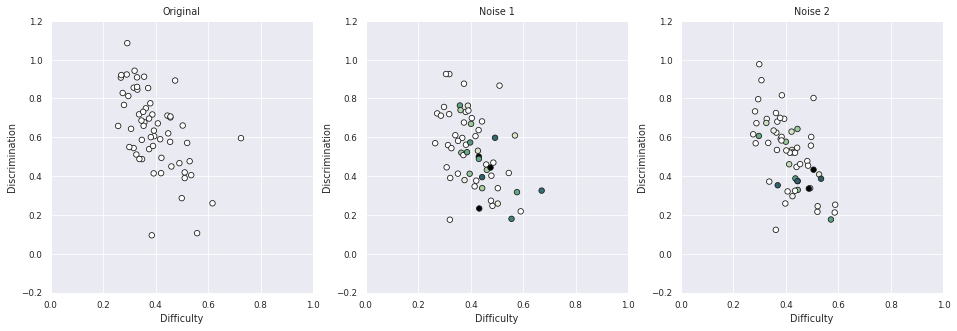

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, noisy in enumerate(names):
    if i>0:
        c = np.absolute(all_files[i][3].iloc[:,-1])
    else:
        c = np.zeros(len(all_files[i][2]))
    axes[i].scatter(all_files[i][2].iloc[:,0], all_files[i][2].iloc[:,1], c = c, cmap = cmap1, edgecolor='k',s=30)
    axes[i].set_title(plts[i])
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([-0.2, 1.2])
    axes[i].set_xlabel('Difficulty')
    axes[i].set_ylabel('Discrimination')
fig.savefig('./Results_IRT/'+name+'/dif_disc')

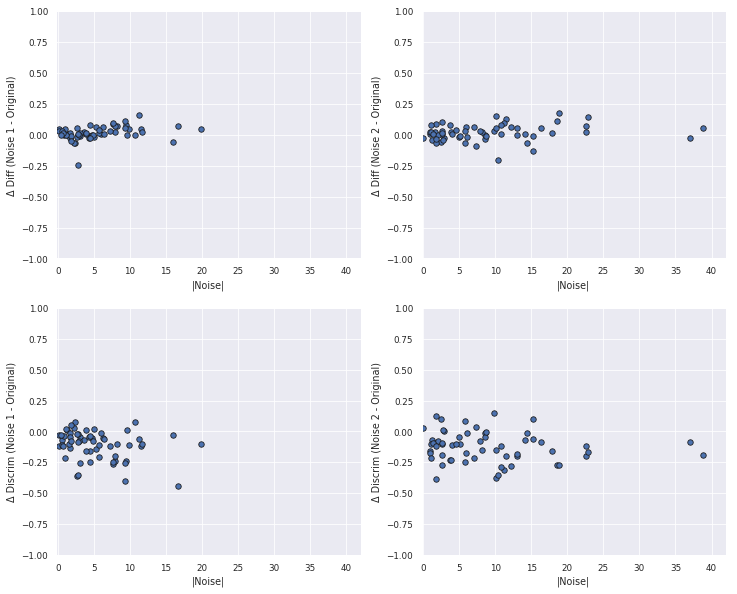

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for h, param in enumerate(['Diff', 'Discrim']):
    for i in range(2):
        axes[h, i].scatter(np.absolute(all_files[i+1][3].iloc[:, -1]), (all_files[i+1][2].iloc[:,h] - all_files[0][2].iloc[:,h]), edgecolor='k',s=30)
        axes[h, i].set_ylim([-1, 1])
        axes[h, i].set_xlim([-.2, 3*max_std])
        axes[h, i].set_xlabel('|Noise|')
        axes[h, i].set_ylabel('Δ '+param+' ('+plts[i+1]+' - Original)')
fig.savefig('./Results_IRT/'+name+'/param_noise')

# Ability

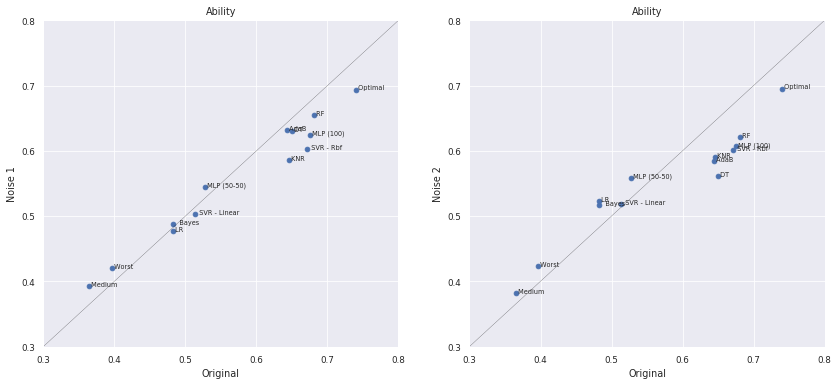

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
mdls = mdls = ['LR', '  Bayes', ' SVR - Linear', ' SVR - Rbf', 'KNR', 'DT', 'RF', 'AdaB', 'MLP (100)', 'MLP (50-50)', 'Optimal', 'Medium', 'Worst']
lim = [0.3, 0.8]

for i, noisy in enumerate(plts[1:]):
    axes[i].scatter(all_files[0][0].iloc[:-1, -1], all_files[i+1][0].iloc[:-1, -1])
    for j, txt in enumerate(mdls):
        axes[i].text(all_files[0][0].iloc[j, -1], all_files[i+1][0].iloc[j, -1], ' '+txt, fontsize=6.5)
    axes[i].set_xlim(lim)
    axes[i].set_ylim(lim)
    axes[i].set_xlabel('Original')
    axes[i].set_ylabel(noisy)
    axes[i].set_title('Ability')
    axes[i].plot(lim, lim, linewidth=0.2, c='black')
fig.savefig('./Results_IRT/'+name+'/ability')